In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
#sns.set(style="darkgrid")
import sys
sys.path.append('./..')
from refuelplot import *
setup()

import statsmodels.api as sm

sns.set_style("darkgrid")

In [2]:
results_path = '/data/users/kgruber/results'
rp_usa = results_path + '/USA'
rp_usa2 = rp_usa + '/results_GWA2'
rp_bra = results_path + '/BRA'
rp_bra2 = rp_bra + '/results_GWA2'

# load USA

load number gridpoints of regions USA

In [3]:
nums_usa = pd.read_csv(rp_usa + '/number_grid_points.csv',index_col=0).drop([2,59]) # drop 2,59 - what is it? new england?

In [4]:
# read results
results_USA = pd.read_pickle(rp_usa + '/results_USA_summary.pkl')
results_USA_tidy = pd.read_pickle(rp_usa + '/results_USA_tidy_summary.pkl')

# load BRA

load correlations regions BRA

In [5]:
nums_bra = pd.read_csv(rp_bra + '/number_grid_points.csv',index_col=0)

In [6]:
# read results
results_BRA_GWA2 = pd.read_csv(rp_bra2 + '/stats_GWA2.csv',index_col=0)
results_BRA_GWA3 = pd.read_csv(rp_bra + '/stats_GWA3.csv',index_col=0)
results_BRA_tidy = pd.concat([results_BRA_GWA2,results_BRA_GWA3],axis=0).rename({'location':'region'},axis=1)
results_BRA_tidy['country'] = 'BRA'

# prepare results and correlations for analysis

### prepare size parameter

In [7]:
nums_usa['scale'] = nums_usa.region.map(pd.Series(results_USA.index.get_level_values(1)).groupby(results_USA.index.get_level_values(3)).first()).values
nums_usa['scale'] = nums_usa.scale.fillna('state')
nums_usa['country'] = 'USA'
nums_bra['country'] = 'BRA'

In [8]:
# calculate "system size" as number between 0 and 1 by divinding by largest number of grid cells per dataset (usa)
ss_usa = nums_usa.copy()
ss_bra = nums_bra.copy()
ss_usa.loc[ss_usa.dataset=='MERRA2','cor'] = nums_usa.cor[nums_usa.dataset=='MERRA2']/nums_usa.cor[nums_usa.dataset=='MERRA2'].max()
ss_usa.loc[ss_usa.dataset=='ERA5','cor'] = nums_usa.cor[nums_usa.dataset=='ERA5']/nums_usa.cor[nums_usa.dataset=='ERA5'].max()
ss_bra.loc[ss_bra.dataset=='MERRA2','cor'] = nums_bra.cor[nums_bra.dataset=='MERRA2']/nums_bra.cor[nums_bra.dataset=='MERRA2'].max()
ss_bra.loc[ss_bra.dataset=='ERA5','cor'] = nums_bra.cor[nums_bra.dataset=='ERA5']/nums_bra.cor[nums_bra.dataset=='ERA5'].max()

### add size parameter to results dataframes

In [9]:
# extract dataset only without GWA
results_BRA_tidy['ds'] = results_BRA_tidy.dataset
results_BRA_tidy['dataset'] = results_BRA_tidy.dataset.str.split('_').apply(lambda x: x[0])
results_USA_tidy['ds'] = results_USA_tidy.dataset
results_USA_tidy['dataset'] = results_USA_tidy.dataset.str.split('_').apply(lambda x: x[0])

In [10]:
# add size to results and use cols as index for matching
cols = ['dataset','region','scale','temp']
results_BRA_tidy['systemsize'] = results_BRA_tidy.set_index(cols).index.map(ss_bra.set_index(cols).cor)
results_USA_tidy['systemsize'] = results_USA_tidy.set_index(cols[:-1]).index.map(ss_usa.set_index(cols[:-1]).cor)

### merge results

In [11]:
results = pd.concat([results_USA_tidy,
                     results_BRA_tidy],
                    axis=0, sort=True, ignore_index=True)

remove gwa from non corrected results and remove duplicates

In [12]:
results.loc[(results.ds!='ERA5_GWA')&(results.ds!='MERRA2_GWA'),'GWA'] = 'none'
results = results[~results.duplicated(subset=['country','ds','param','region','scale','systemsize','temp','value'])]

add gwa to dataset

In [13]:
results['ds2'] = results.ds
results['ds2'][results.GWA!='none'] = results.dataset[results.GWA!='none'] + '_' + results.GWA[results.GWA!='none']

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
results.to_pickle(results_path + '/results_USABRA_gridpoints.pkl')

In [34]:
results['systemsize2'] = pd.cut(results.systemsize,
                                pd.IntervalIndex.from_tuples([(0,0.1),(0.1,0.2), (0.2,0.3), (0.3,0.4), (0.4,0.5), (0.5,1)]))

# plot results

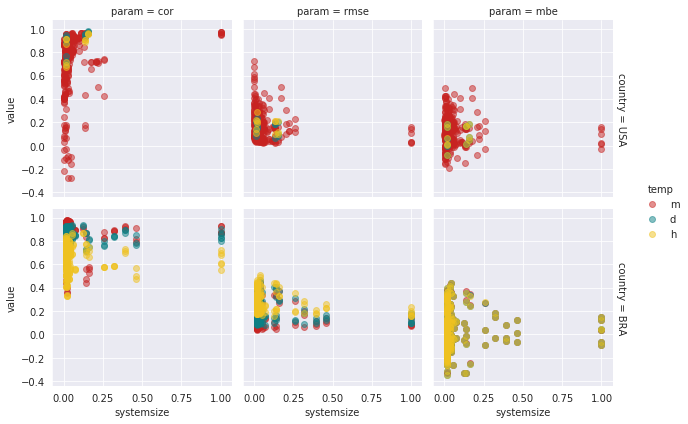

In [24]:
sns.FacetGrid(col='param',row='country',
              hue='temp',data=results[results.param!='avg'], margin_titles=True
             ).map(plt.scatter,'systemsize','value',alpha=0.5).add_legend()

## correlations

correlations vs system size in Brazil and USA per temporal scale

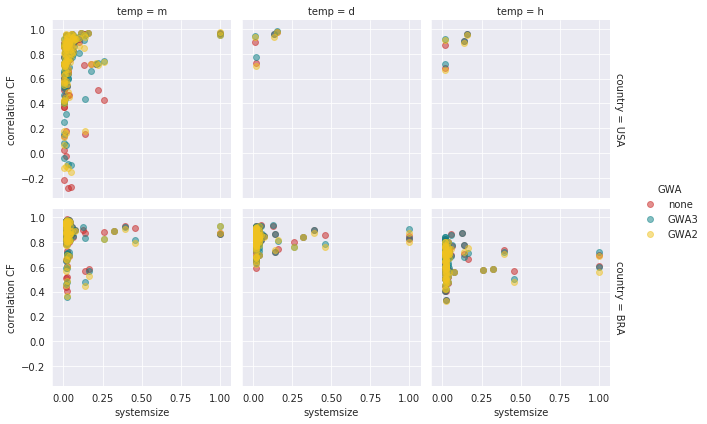

In [52]:
sns.FacetGrid(col='temp',row='country',
              hue='GWA',data=results[results.param=='cor'], margin_titles=True
             ).map(plt.scatter,'systemsize','value',alpha=0.5).add_legend().set_axis_labels("systemsize", "correlation CF")

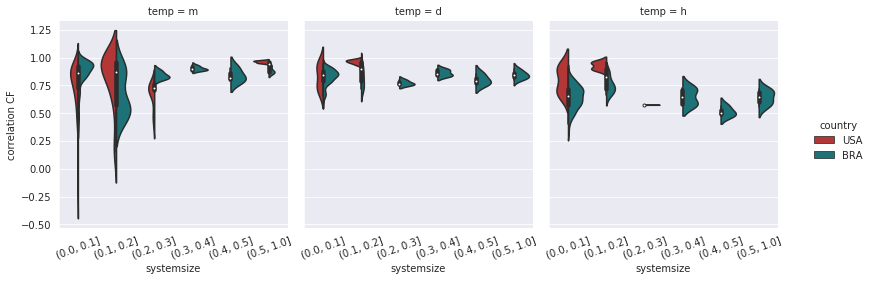

In [44]:
sns.catplot(x = 'systemsize2', y = 'value', col='temp',#row='GWA',
              hue='country', kind='violin',split=True,
            height=3.8, aspect=1,
            data=results[results.param=='cor'], margin_titles=True
           ).set_axis_labels("systemsize", "correlation CF").set_xticklabels(rotation=20)

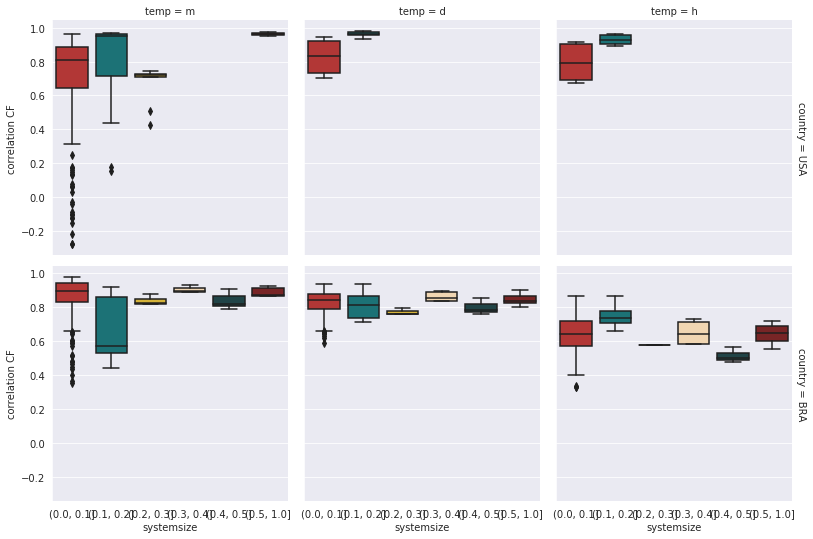

In [50]:
sns.catplot(x = 'systemsize2', y = 'value', col='temp',row='country',
              kind='box',#hue='country',
            height=3.8, aspect=1,
            data=results[results.param=='cor'], margin_titles=True
           ).set_axis_labels("systemsize", "correlation CF")#.set_xticklabels(rotation=20)

correlations per temporal scale and GWA in Brazil and USA

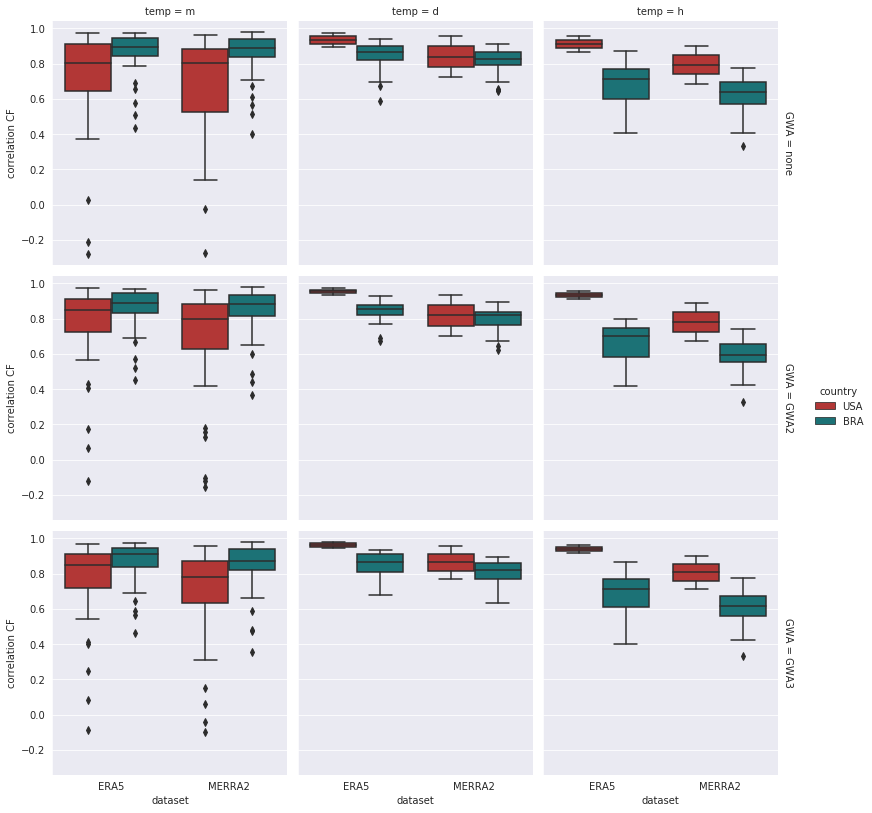

In [66]:
sns.catplot(x = 'dataset', y = 'value', col='temp',row='GWA',
              hue='country', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='cor'], margin_titles=True,
            row_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "correlation CF")#.set_titles("{row_name} {col_name}")

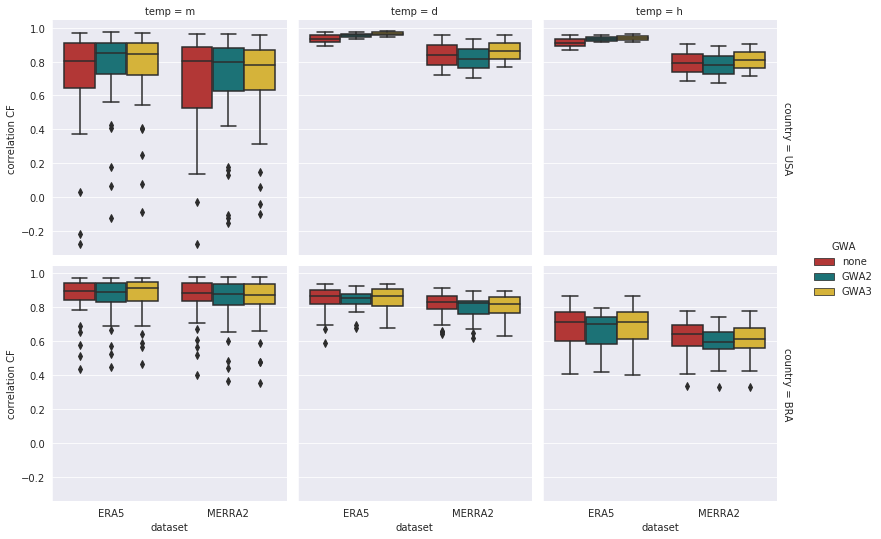

In [63]:
sns.catplot(x = 'dataset', y = 'value', col='temp',row='country',
              hue='GWA', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='cor'], margin_titles=True,
            hue_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "correlation CF")#.set_titles("{row_name} {col_name}")

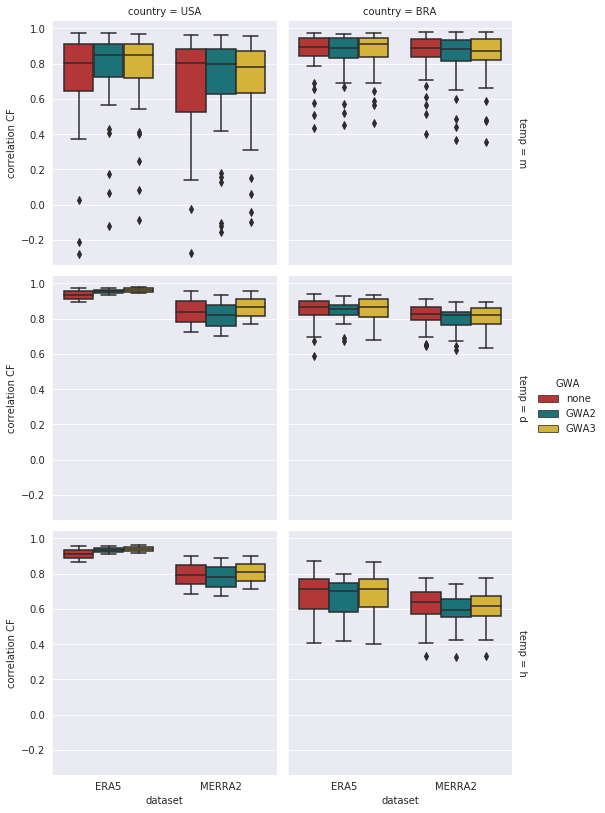

In [64]:
sns.catplot(x = 'dataset', y = 'value', col='country',row='temp',
              hue='GWA', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='cor'], margin_titles=True,
            hue_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "correlation CF")#.set_titles("{row_name} {col_name}")

## RMSES

RMSEs vs system size in Brazil and USA per temporal scale

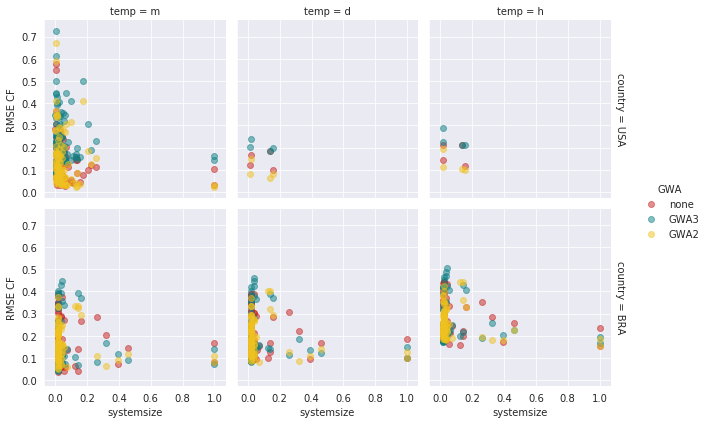

In [53]:
sns.FacetGrid(col='temp',row='country',
              hue='GWA',data=results[results.param=='rmse'], margin_titles=True
             ).map(plt.scatter,'systemsize','value',alpha=0.5).add_legend().set_axis_labels("systemsize", "RMSE CF")

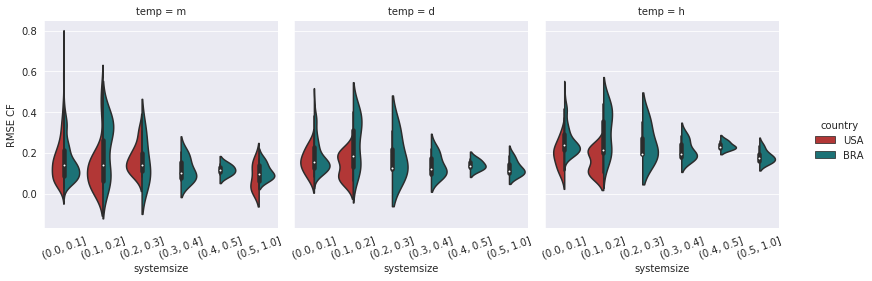

In [55]:
sns.catplot(x = 'systemsize2', y = 'value', col='temp',#row='GWA',
              hue='country', kind='violin',split=True,
            height=3.8, aspect=1,
            data=results[results.param=='rmse'], margin_titles=True
           ).set_axis_labels("systemsize", "RMSE CF").set_xticklabels(rotation=20)

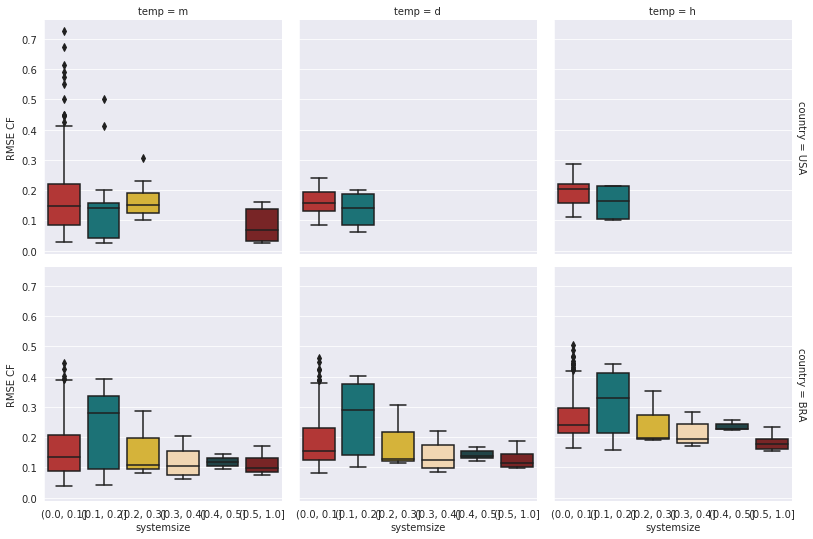

In [57]:
sns.catplot(x = 'systemsize2', y = 'value', col='temp',row='country',
              kind='box',#hue='country',
            height=3.8, aspect=1,
            data=results[results.param=='rmse'], margin_titles=True
           ).set_axis_labels("systemsize", "RMSE CF")#.set_xticklabels(rotation=20)

RMSEs per temporal scale and GWA in Brazil and USA

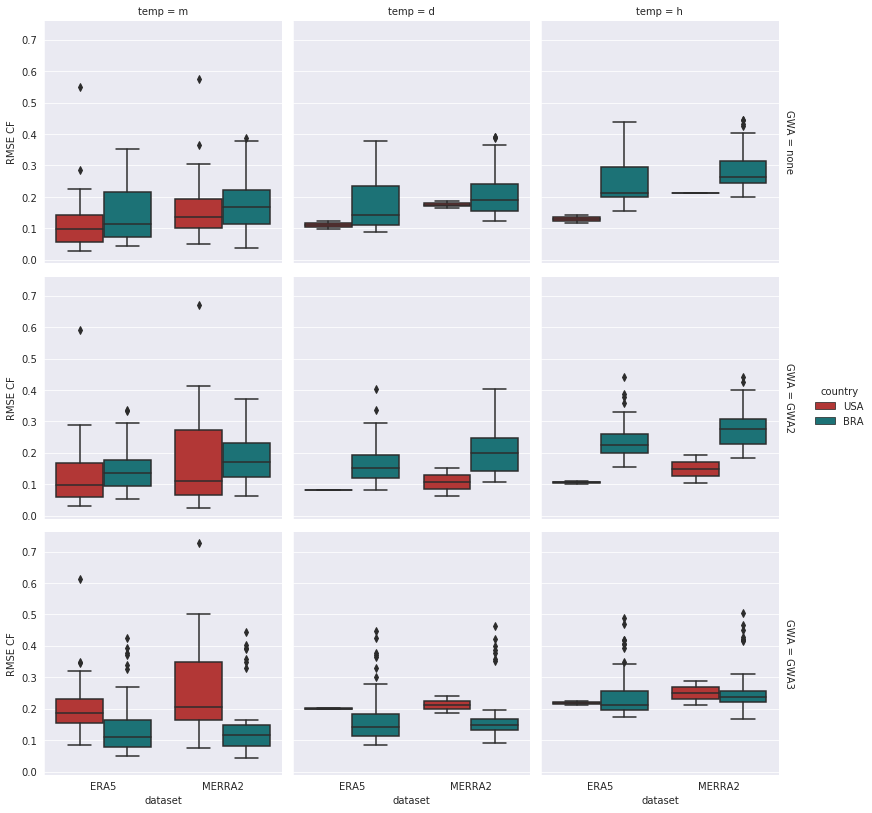

In [65]:
sns.catplot(x = 'dataset', y = 'value', col='temp',row='GWA',
              hue='country', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='rmse'], margin_titles=True,
            row_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "RMSE CF")#.set_titles("{row_name} {col_name}")

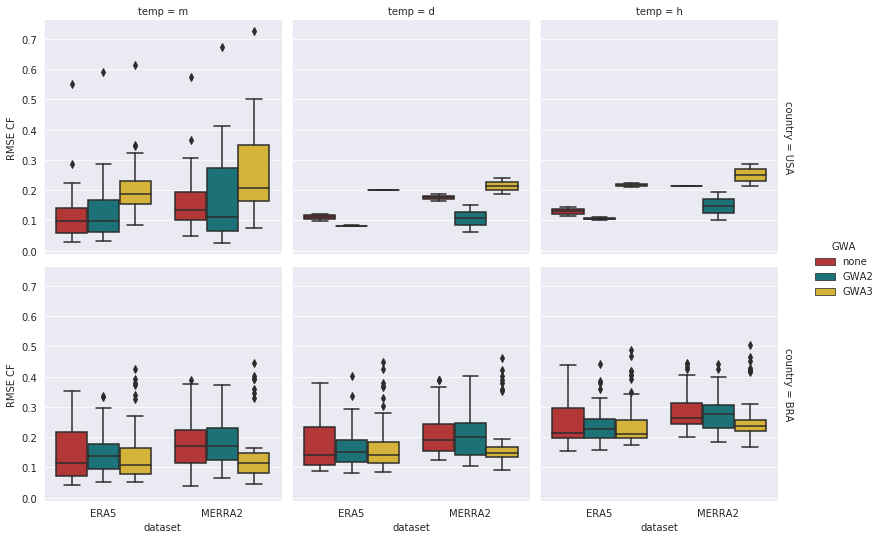

In [61]:
sns.catplot(x = 'dataset', y = 'value', col='temp',row='country',
              hue='GWA', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='rmse'], margin_titles=True,
            hue_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "RMSE CF")#.set_titles("{row_name} {col_name}")

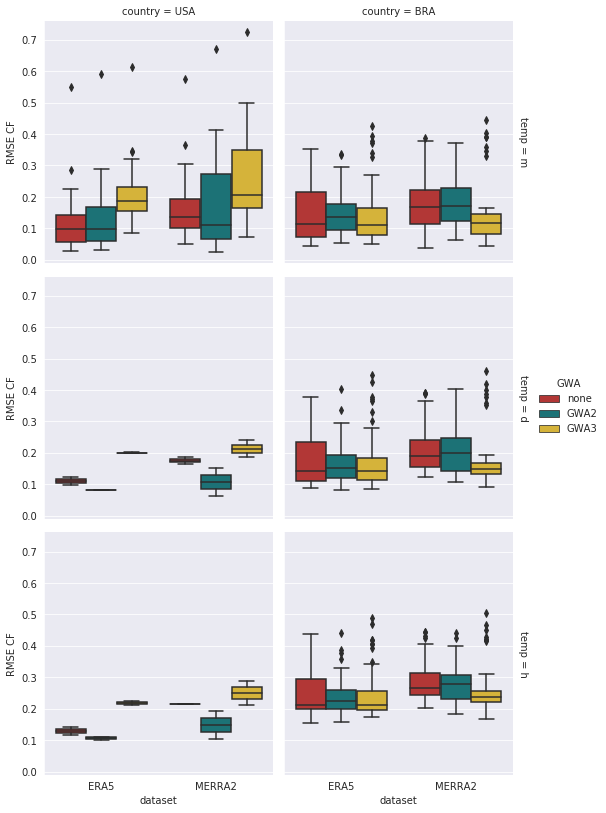

In [62]:
sns.catplot(x = 'dataset', y = 'value', col='country',row='temp',
              hue='GWA', kind='box',
            height=3.8, aspect=1,
            data=results[results.param=='rmse'], margin_titles=True,
            hue_order = ['none','GWA2','GWA3']
           ).set_axis_labels("dataset", "RMSE CF")#.set_titles("{row_name} {col_name}")